In [13]:
import argparse
import os

import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import inception_resnet_v1

In [14]:
def eval(aligned_images, model_path):
    with tf.Graph().as_default():
        sess = tf.Session()
        images_pl = tf.placeholder(tf.float32, shape=[None, 160, 160, 3], name='input_image')
        images = tf.map_fn(lambda frame: tf.reverse_v2(frame, [-1]), images_pl) #BGR TO RGB
        images_norm = tf.map_fn(lambda frame: tf.image.per_image_standardization(frame), images)
        train_mode = tf.placeholder(tf.bool)
        age_logits, gender_logits, _ = inception_resnet_v1.inference(images_norm, keep_probability=0.8,
                                                                     phase_train=train_mode,
                                                                     weight_decay=1e-5)
        gender = tf.argmax(tf.nn.softmax(gender_logits), 1)
        age_ = tf.cast(tf.constant([i for i in range(0, 101)]), tf.float32)
        age = tf.reduce_sum(tf.multiply(tf.nn.softmax(age_logits), age_), axis=1)
        init_op = tf.group(tf.global_variables_initializer(),
                           tf.local_variables_initializer())
        sess.run(init_op)
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state(model_path)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            print("restore and continue training!")
        else:
            pass
        return sess.run([age, gender], feed_dict={images_pl: aligned_images, train_mode: False})


In [15]:
def load_image(image_path, shape_predictor):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(shape_predictor)
    fa = FaceAligner(predictor, desiredFaceWidth=160)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    # image = imutils.resize(image, width=256)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 2)
    rect_nums = len(rects)
    XY, aligned_images = [], []
    if rect_nums == 0:
        aligned_images.append(image)
        return aligned_images, image, rect_nums, XY
    else:
        for i in range(rect_nums):
            aligned_image = fa.align(image, gray, rects[i])
            aligned_images.append(aligned_image)
            (x, y, w, h) = rect_to_bb(rects[i])
            image = cv2.rectangle(image, (x, y), (x + w, y + h), color=(255, 0, 0), thickness=2)
            XY.append((x, y))
        return np.array(aligned_images), image, rect_nums, XY

In [16]:
def draw_label(image, point, ages, genders,font=cv2.FONT_HERSHEY_SIMPLEX,
               font_scale=1, thickness=2):
    for i in range(len(point)):
        label = "{}, {}".format(int(ages[i]), "F" if genders[i] == 0 else "M")
        size = cv2.getTextSize(label, font, font_scale, thickness)[0]
        x, y = point[i]
        cv2.rectangle(image, (x, y - size[1]), (x + size[0], y), (255, 0, 0), cv2.FILLED)
#         cv2.put
        cv2.putText(image, label, point[i], font, font_scale, (255, 255, 255), thickness)

INFO:tensorflow:Restoring parameters from ../weights/models_gender_and_age/model.ckpt-14001
restore and continue training!
[28.160244 34.12142  33.125237 26.898468] [1 0 1 0]


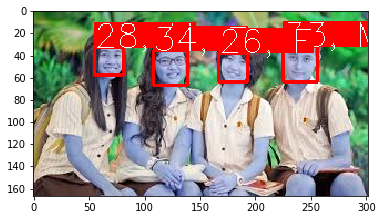

In [19]:
aligned_image, image, rect_nums, XY = load_image("../data/test/download (1).jpeg", "../weights/shape_predictor_68_face_landmarks.dat")
ages, genders = eval(aligned_image, "../weights/models_gender_and_age/")
print(ages, genders)
draw_label(image, XY, ages, genders, font_scale=1, thickness=1)
plt.imshow(image)